# MALARIA DETECTION

## Motivation to work on  the Malaria Detection problem

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.

Malaria is an acute febrile illness. In a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.

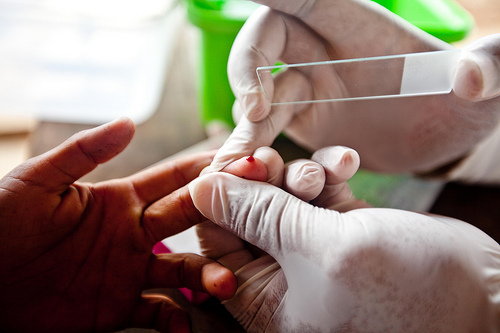

According to WHO protocol, diagnosis typically involves intensive examination of the blood smear at 100X magnification. Trained people manually count how many red blood cells contain parasites out of 5,000 cells. Thus, the detection of Malaria should be automized for the fast detection and treatment to prevent life losses.


## Dataset 

The dataset for Malaria detection was carefully collected and annotated by the researchers at the Lister Hill National Center for Biomedical Communications (LHNCBC), part of the National Library of Medicine (NLM). The dataset is [publicly available](https://ceb.nlm.nih.gov/repositories/malaria-datasets/). The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.


In [1]:
import dl
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cv2
import h5py
from random import shuffle
from math import ceil

In [2]:
from malaria_detection import read_images, train_test_set
from collections import Counter
# in the cell_images.zip file, we have 27558 cell images. Half of them are parasitized and the other half are
# the images of uninfected cells.
# Firstly, randomly mix the data one file. Below function will mix all the images in infected and healthy image files
# into one file.
files_df = read_images()

# Now, let's create train, validation, and the test splits of data. 
# %30 of all data will be the test set.
# The rest %70 of data will be divided into %90 train and %10 validation data.
train_files, train_labels, val_files, val_labels, test_files, test_labels = train_test_set(files_df)
print("Train data shape : ", train_files.shape)
print("Validation data shape : ", val_files.shape)
print("Test data shape : ", test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Train data shape :  (17361,)
Validation data shape :  (1929,)
Test data shape :  (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [ ]:
from malaria_detection import discover_dataset
# After making train, validation and test splits, we need to resize the images, since all of them have different sizes.
# To find the best size, we will go through all the train set and will find maximum, minimum, median and average
# image sizes.

train_img_dims = discover_dataset(train_files)
print('Min Dimensions:', np.min(train_img_dims, axis=0))
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

In [3]:
# This operation might take a while.
from malaria_detection import load_images
from sklearn.preprocessing import LabelEncoder

IMG_DIM = (100, 100) # Here you can change the size.
hdf5_file = None

###################################################
hdf5_datapath = '../Malaria_Dataset/data_28.hdf5' # Here you can directly define the path to your hdf5 data file.

# It can only be used ../Malaria_Dataset/data_28.hdf5 or ../Malaria_Dataset/data_64.hdf5
###################################################
if not os.path.isfile(hdf5_datapath): 
    train_shape = (len(train_files), 100, 100 , 3)
    val_shape = (len(val_files), 100, 100, 3)
    test_shape = (len(test_files), 100, 100, 3)
    
    # In the label files, all images anotated either as healthy or malaria.
    # By using the label encoder, we will encode all of them as 0-healthy and 1-malaria
    le = LabelEncoder()
    le.fit(train_labels)
    train_labels_enc = le.transform(train_labels)
    val_labels_enc = le.transform(val_labels)
    test_labels_enc = le.transform(test_labels)
    print(train_labels[:6], train_labels_enc[:6])

    hdf5_file = h5py.File(hdf5_datapath, mode='w')
    
    hdf5_file.create_dataset("train_img", train_shape, np.float32)
    hdf5_file.create_dataset("val_img", val_shape, np.float32)
    hdf5_file.create_dataset("test_img", test_shape, np.float32)
    hdf5_file.create_dataset("train_mean", train_shape[1:], np.float32)

    hdf5_file.create_dataset("train_labels", (len(train_labels),), np.int8)
    hdf5_file["train_labels"][...] = train_labels_enc
    hdf5_file.create_dataset("val_labels", (len(val_labels),), np.int8)
    hdf5_file["val_labels"][...] = val_labels_enc
    hdf5_file.create_dataset("test_labels", (len(test_labels),), np.int8)
    hdf5_file["test_labels"][...] = test_labels_enc

    mean = np.zeros(train_shape[1:], np.float32)
    
    # Here all the images are loaded into hdf5 file.
    load_images(train_files, train_labels, val_files, test_files, mean, hdf5_file)
    hdf5_file.close() # After loading of all images hdf5 file is closed.
    
    

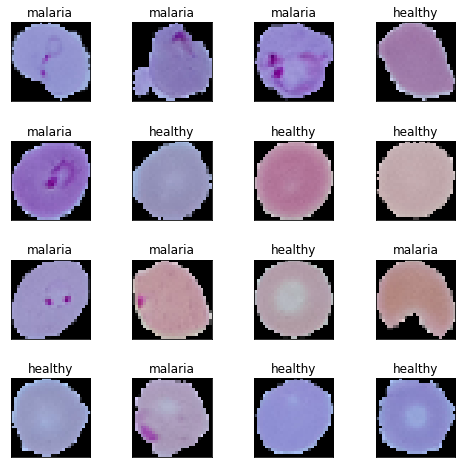

In [4]:
# Let's plot some random samples from our training samples, to see our data format properly.

# The hdf5 file is opened in the read format.
hdf5_file = h5py.File(hdf5_datapath, "r")

# the keys to reach the correct data in hdf5 file.
# hdf5_file["train_img"] --> training images
# hdf5_file["train_labels"] --> training labels
# hdf5_file["val_img"] --> validation images
# hdf5_file["val_labels"] --> validation labels
# hdf5_file["test_img"] --> test images
# hdf5_file["test_labels"] --> test labels
# hdf5_file["train_mean"] --> the mean of all training data.

plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , hdf5_file["train_img"].shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])
plt.show()

## Mini Batch Calculation 

In [5]:
BATCH_SIZE = 10 # You can change the batch size to something else.
EPOCH_SIZE = 3 # You can change the number of epochs.
data_num = hdf5_file["train_img"].shape[0] # Total number of samples
validation_set_num = hdf5_file["val_img"].shape[0]


# create list of batches to shuffle the data
batches_list = list(range(int(ceil(float(data_num) / BATCH_SIZE))))
shuffle(batches_list)

# create list of validation batches to shuffle the data
val_batches_list = list(range(int(ceil(float(validation_set_num) / BATCH_SIZE))))
shuffle(val_batches_list)

## Building LeNet Architecture

There are two different architectures which is used. 
First of all LeNet is used with the input size 28x28x3 images first, later with the image size 64x64x3. 

In [6]:
net =  dl.Network()

# LeNet Architecture
output_size_conv1, num_of_outputs_conv1 = net.conv(hdf5_file['train_img'][0].shape[0],
                                                   hdf5_file['train_img'][0].shape[2],
                                                   5, # filter size
                                                   3, # filter depth
                                                   6, # number of filters
                                                   1, # stride
                                                   0) # padding

output_size_relu1_h, output_size_relu1_w, num_of_outputs_relu1 = net.relu(
    num_of_outputs_conv1, # number of the feature maps
    output_size_conv1, #height of one of the feature map
    output_size_conv1 # width of one of the feature map
)

output_size_pooling1, num_of_outputs_pooling_1 = net.maxpool(
    output_size_relu1_h,
    num_of_outputs_relu1,
    2, # filter size
    2, # stride
    0 # padding
)

output_size_conv2, num_of_outputs_conv2 = net.conv(
    output_size_pooling1,
    num_of_outputs_pooling_1,
    5, # filter size
    6, # filter dept
    16, # number of filters
    1, #stride
    0 # padding
)

output_size_relu2_h, output_size_relu2_w, num_of_outputs_relu2 = net.relu(
    num_of_outputs_conv2, # number of the feature maps
    output_size_conv2, #height of one of the feature map
    output_size_conv2 # width of one of the feature map
)

output_size_pooling2, num_of_outputs_pooling_2 = net.maxpool(
    output_size_relu2_h,
    num_of_outputs_relu2,
    2, # filter size
    2, # stride
    0 # padding
)

output_size_fully1_h, output_size_fully1_w, num_of_outputs_fully1 = net.fullyConnected(
    output_size_pooling2,
    output_size_pooling2,
    num_of_outputs_pooling_2,
    32
)

output_size_relu4_h, output_size_relu4_w, num_of_outputs_relu4 = net.relu(
    num_of_outputs_fully1, # number of the feature maps
    output_size_fully1_h, # height of one of the feature map
    output_size_fully1_w # width of the feature map
)

output_size_fully2_h, output_size_fully2_w, num_of_outputs_fully2 = net.fullyConnected(
    output_size_relu4_h,
    output_size_relu4_w, # 1
    num_of_outputs_relu4,
    2
)

output_size_softmax5_h, output_size_softmax5_w, num_of_outputs_sigmoid5 = net.softmax(
    num_of_outputs_fully2, # number of the feature maps
    output_size_fully2_h, #height of one of the feature map,
    output_size_fully2_w # 1
)

## Testing of LeNet Network Architecture with SGD by Using 28x28x3 images

In [7]:
net.loadWeights("../Malaria_Dataset/training_sgd_normal_28/training_sgd_28.txt")

n_values = 2
test_data_num = hdf5_file["test_labels"].shape[0]
#####################################################
# Since we don't want to load all the data at once, # 
# we need to divide it into batches. From the below #
# line you can change the batch size for the path.  #
#####################################################
TEST_BATCH_SIZE = 10
test_batches_list = list(range(int(ceil(float(test_data_num) / TEST_BATCH_SIZE))))
shuffle(test_batches_list)

num_of_correct_guesses = 0
num_of_correct_guesses_10 = 0

for n, i in enumerate(test_batches_list):
    i_s = i * TEST_BATCH_SIZE  # index of the first image in this batch
    i_e = min([(i + 1) * TEST_BATCH_SIZE, test_data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    test_images = hdf5_file["test_img"][i_s:i_e, ...]
    test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],
                                      test_images.shape[1], test_images.shape[2]) # reshaped to size 22046, 3, 64, 64

    # read labels and convert to one hot encoding
    test_labels = hdf5_file["test_labels"][i_s:i_e]
    test_labels_one_hot = np.eye(n_values)[test_labels]

    temp = net.test(test_images / 255., test_labels_one_hot)
    num_of_correct_guesses += temp
    num_of_correct_guesses_10 += temp

    if n % 10 == 9:    # print every 10 batches
        print('Batch: {}, Accuracy: {}'.format(n+1,num_of_correct_guesses_10 * 100 / float(TEST_BATCH_SIZE * 10)))
        num_of_correct_guesses_10 = 0

print('Total test Accuracy : {}'.format(num_of_correct_guesses / float(test_data_num)))

Batch: 10, Accuracy: 62.0
Batch: 20, Accuracy: 54.0
Batch: 30, Accuracy: 58.0
Batch: 40, Accuracy: 65.0
Batch: 50, Accuracy: 57.0
Batch: 60, Accuracy: 59.0
Batch: 70, Accuracy: 51.0
Batch: 80, Accuracy: 55.0
Batch: 90, Accuracy: 56.0
Batch: 100, Accuracy: 59.0
Batch: 110, Accuracy: 54.0
Batch: 120, Accuracy: 57.0
Batch: 130, Accuracy: 55.0
Batch: 140, Accuracy: 55.0
Batch: 150, Accuracy: 59.0
Batch: 160, Accuracy: 54.0
Batch: 170, Accuracy: 55.0
Batch: 180, Accuracy: 59.0
Batch: 190, Accuracy: 63.0
Batch: 200, Accuracy: 45.0
Batch: 210, Accuracy: 60.0
Batch: 220, Accuracy: 55.0
Batch: 230, Accuracy: 47.0
Batch: 240, Accuracy: 62.0
Batch: 250, Accuracy: 47.0
Batch: 260, Accuracy: 61.0
Batch: 270, Accuracy: 69.0
Batch: 280, Accuracy: 60.0
Batch: 290, Accuracy: 54.0
Batch: 300, Accuracy: 54.0
Batch: 310, Accuracy: 55.0
Batch: 320, Accuracy: 69.0
Batch: 330, Accuracy: 51.0
Batch: 340, Accuracy: 46.0
Batch: 350, Accuracy: 53.0
Batch: 360, Accuracy: 50.0
Batch: 370, Accuracy: 68.0
Batch: 380

## Visual Test Results of LeNet Network Architecture with SGD

Below part is for picking a random 16 images, you can run it again to see the test results with different images.

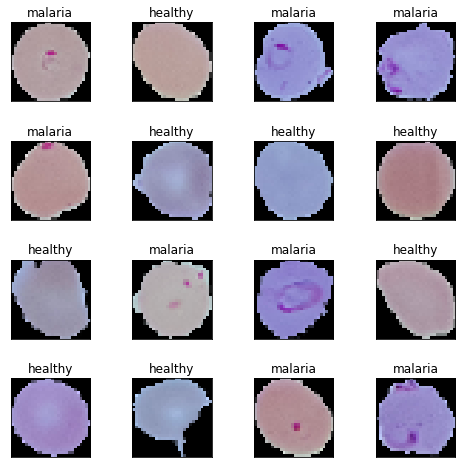

In [9]:
plt.figure(1 , figsize = (8 , 8))
n = 0
mask = []
for i in range(16):
    n += 1
    r = np.random.randint(0 , hdf5_file["train_img"].shape[0] , 1)
    mask.append(r[0])
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])
plt.show()

In [15]:
predictions = []
for sample_idx in mask:
    sample = hdf5_file["train_img"][sample_idx]/ 255.
    sample = sample.reshape(sample.shape[2], sample.shape[0], sample.shape[1])
    label = hdf5_file["train_labels"][sample_idx]
    predicted_label = net.predict(sample)
    if predicted_label == 0:
        predictions.append("healthy")
    else:
        predictions.append("malaria")

## Predictions

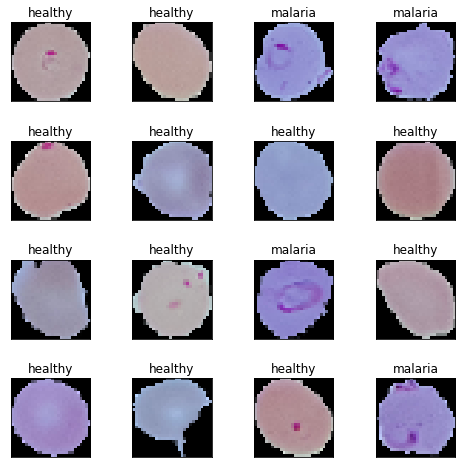

In [16]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i, sample_idx in enumerate(mask):
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][sample_idx]/255.)
    plt.title('{}'.format(predictions[i]))
    plt.xticks([]) , plt.yticks([])
plt.show()

## Testing of LeNet Network Architecture with Momentum Gradient Descent by Using 28x28x3 images

In [23]:
net.loadWeights("../Malaria_Dataset/training_momentum_normal_28/training_normal_28_epoch_3.txt")

n_values = 2
test_data_num = hdf5_file["test_labels"].shape[0]
#####################################################
# Since we don't want to load all the data at once, # 
# we need to divide it into batches. From the below #
# line you can change the batch size for the path.  #
#####################################################
TEST_BATCH_SIZE = 10
test_batches_list = list(range(int(ceil(float(test_data_num) / TEST_BATCH_SIZE))))
shuffle(test_batches_list)

num_of_correct_guesses = 0
num_of_correct_guesses_10 = 0

for n, i in enumerate(test_batches_list):
    i_s = i * TEST_BATCH_SIZE  # index of the first image in this batch
    i_e = min([(i + 1) * TEST_BATCH_SIZE, test_data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    test_images = hdf5_file["test_img"][i_s:i_e, ...]
    test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],
                                      test_images.shape[1], test_images.shape[2]) # reshaped to size 22046, 3, 64, 64

    # read labels and convert to one hot encoding
    test_labels = hdf5_file["test_labels"][i_s:i_e]
    test_labels_one_hot = np.eye(n_values)[test_labels]

    temp = net.test(test_images / 255., test_labels_one_hot)
    num_of_correct_guesses += temp
    num_of_correct_guesses_10 += temp

    if n % 10 == 9:    # print every 10 batches
        print('Batch: {}, Accuracy: {}'.format(n+1,num_of_correct_guesses_10 * 100 / float(TEST_BATCH_SIZE * 10)))
        num_of_correct_guesses_10 = 0

print('Total test Accuracy : {}'.format(num_of_correct_guesses / float(test_data_num)))

Batch: 10, Accuracy: 72.0
Batch: 20, Accuracy: 60.0
Batch: 30, Accuracy: 69.0
Batch: 40, Accuracy: 64.0
Batch: 50, Accuracy: 62.0
Batch: 60, Accuracy: 65.0
Batch: 70, Accuracy: 59.0
Batch: 80, Accuracy: 67.0
Batch: 90, Accuracy: 57.0
Batch: 100, Accuracy: 68.0
Batch: 110, Accuracy: 58.0
Batch: 120, Accuracy: 70.0
Batch: 130, Accuracy: 62.0
Batch: 140, Accuracy: 64.0
Batch: 150, Accuracy: 56.0
Batch: 160, Accuracy: 64.0
Batch: 170, Accuracy: 64.0
Batch: 180, Accuracy: 68.0
Batch: 190, Accuracy: 66.0
Batch: 200, Accuracy: 69.0
Batch: 210, Accuracy: 61.0
Batch: 220, Accuracy: 69.0
Batch: 230, Accuracy: 55.0
Batch: 240, Accuracy: 59.0
Batch: 250, Accuracy: 67.0
Batch: 260, Accuracy: 58.0
Batch: 270, Accuracy: 60.0
Batch: 280, Accuracy: 65.0
Batch: 290, Accuracy: 57.0
Batch: 300, Accuracy: 65.0
Batch: 310, Accuracy: 65.0
Batch: 320, Accuracy: 65.0
Batch: 330, Accuracy: 62.0
Batch: 340, Accuracy: 71.0
Batch: 350, Accuracy: 71.0
Batch: 360, Accuracy: 62.0
Batch: 370, Accuracy: 63.0
Batch: 380

## Visual Test Results of LeNet Network Architecture with Momentum

In [24]:
predictions = []
for sample_idx in mask:
    sample = hdf5_file["train_img"][sample_idx]/ 255.
    sample = sample.reshape(sample.shape[2], sample.shape[0], sample.shape[1])
    label = hdf5_file["train_labels"][sample_idx]
    predicted_label = net.predict(sample)
    if predicted_label == 0:
        predictions.append("healthy")
    else:
        predictions.append("malaria")

## Predictions

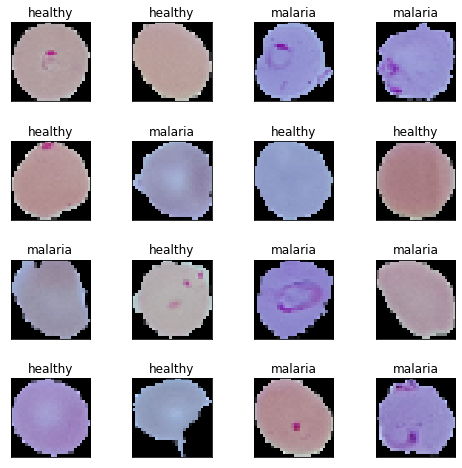

In [25]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i, sample_idx in enumerate(mask):
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][sample_idx]/255.)
    plt.title('{}'.format(predictions[i]))
    plt.xticks([]) , plt.yticks([])
plt.show()

## Testing of LeNet Network Architecture with SGD by Using 64x64x3 images
Before running this part, don't forget to change the hdf5_datapath to ../Malaria_Dataset/data_64.hdf5


In [12]:
net.loadWeights("../Malaria_Dataset/training_sgd_normal_64/training_sgd_normal_64.txt")

n_values = 2
test_data_num = hdf5_file["test_labels"].shape[0]
#####################################################
# Since we don't want to load all the data at once, # 
# we need to divide it into batches. From the below #
# line you can change the batch size for the path.  #
#####################################################
TEST_BATCH_SIZE = 10
test_batches_list = list(range(int(ceil(float(test_data_num) / TEST_BATCH_SIZE))))
shuffle(test_batches_list)

num_of_correct_guesses = 0
num_of_correct_guesses_10 = 0

for n, i in enumerate(test_batches_list):
    i_s = i * TEST_BATCH_SIZE  # index of the first image in this batch
    i_e = min([(i + 1) * TEST_BATCH_SIZE, test_data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    test_images = hdf5_file["test_img"][i_s:i_e, ...]
    test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],
                                      test_images.shape[1], test_images.shape[2]) # reshaped to size 22046, 3, 64, 64

    # read labels and convert to one hot encoding
    test_labels = hdf5_file["test_labels"][i_s:i_e]
    test_labels_one_hot = np.eye(n_values)[test_labels]

    temp = net.test(test_images / 255., test_labels_one_hot)
    num_of_correct_guesses += temp
    num_of_correct_guesses_10 += temp

    if n % 10 == 9:    # print every 10 batches
        print('Batch: {}, Accuracy: {}'.format(n+1,num_of_correct_guesses_10 * 100 / float(TEST_BATCH_SIZE * 10)))
        num_of_correct_guesses_10 = 0

print('Total test Accuracy : {}'.format(num_of_correct_guesses / float(test_data_num)))

Batch: 10, Accuracy: 67.0
Batch: 20, Accuracy: 62.0
Batch: 30, Accuracy: 66.0
Batch: 40, Accuracy: 60.0
Batch: 50, Accuracy: 54.0
Batch: 60, Accuracy: 63.0
Batch: 70, Accuracy: 65.0
Batch: 80, Accuracy: 63.0
Batch: 90, Accuracy: 72.0
Batch: 100, Accuracy: 63.0
Batch: 110, Accuracy: 57.0
Batch: 120, Accuracy: 70.0
Batch: 130, Accuracy: 67.0
Batch: 140, Accuracy: 61.0
Batch: 150, Accuracy: 64.0
Batch: 160, Accuracy: 57.0
Batch: 170, Accuracy: 64.0
Batch: 180, Accuracy: 60.0
Batch: 190, Accuracy: 63.0
Batch: 200, Accuracy: 64.0
Batch: 210, Accuracy: 57.0
Batch: 220, Accuracy: 66.0
Batch: 230, Accuracy: 64.0
Batch: 240, Accuracy: 61.0
Batch: 250, Accuracy: 60.0
Batch: 260, Accuracy: 72.0
Batch: 270, Accuracy: 65.0
Batch: 280, Accuracy: 62.0
Batch: 290, Accuracy: 76.0
Batch: 300, Accuracy: 67.0
Batch: 310, Accuracy: 66.0
Batch: 320, Accuracy: 65.0
Batch: 330, Accuracy: 67.0
Batch: 340, Accuracy: 67.0
Batch: 350, Accuracy: 55.0
Batch: 360, Accuracy: 78.0
Batch: 370, Accuracy: 61.0
Batch: 380

## Visual Test Results of LeNet Network Architecture with SGD by using 64x64x3 images

Below part is for picking a random 16 images, you can run it again to see the test results with different images.

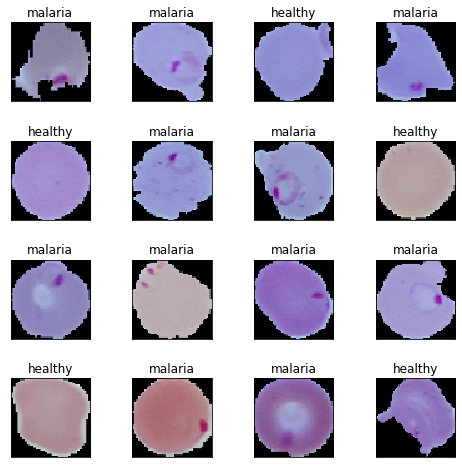

In [27]:
plt.figure(1 , figsize = (8 , 8))
n = 0
mask = []
for i in range(16):
    n += 1
    r = np.random.randint(0 , hdf5_file["train_img"].shape[0] , 1)
    mask.append(r[0])
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])
plt.show()

In [28]:
predictions = []
for sample_idx in mask:
    sample = hdf5_file["train_img"][sample_idx]/ 255.
    sample = sample.reshape(sample.shape[2], sample.shape[0], sample.shape[1])
    label = hdf5_file["train_labels"][sample_idx]
    predicted_label = net.predict(sample)
    if predicted_label == 0:
        predictions.append("healthy")
    else:
        predictions.append("malaria")

## Predictions

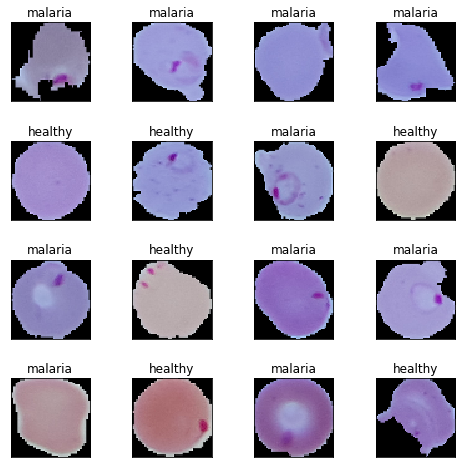

In [29]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i, sample_idx in enumerate(mask):
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][sample_idx]/255.)
    plt.title('{}'.format(predictions[i]))
    plt.xticks([]) , plt.yticks([])
plt.show()

## LeNet by using the receptive field property

In [26]:
net = dl.Network()

# receptive field LeNet

output_size_conv1, num_of_outputs_conv1 = net.conv(hdf5_file['train_img'][0].shape[0],
                                                   hdf5_file['train_img'][0].shape[2],
                                                   3, # filter size
                                                   3, # filter depth
                                                   8, # number of filters
                                                   1, # stride
                                                   0) # padding


output_size_relu1_h, output_size_relu1_w, num_of_outputs_relu1 = net.relu(
    num_of_outputs_conv1, # number of the feature maps
    output_size_conv1, #height of one of the feature map
    output_size_conv1 # width of one of the feature map
)

output_size_conv2, num_of_outputs_conv2 = net.conv(
    output_size_relu1_h,
    num_of_outputs_relu1,
    3, # filter size
    8, # filter dept
    8, # number of filters
    1, #stride
    0 # padding
)


output_size_relu2_h, output_size_relu2_w, num_of_outputs_relu2 = net.relu(
    num_of_outputs_conv2, # number of the feature maps
    output_size_conv2, #height of one of the feature map
    output_size_conv2 # width of one of the feature map
)


output_size_pooling2, num_of_outputs_pooling_2 = net.maxpool(
    output_size_relu2_h,
    num_of_outputs_relu2,
    2, # filter size
    2, # stride
    0 # padding
)


output_size_conv3, num_of_outputs_conv3 = net.conv(
    output_size_pooling2,
    num_of_outputs_pooling_2,
    3, # filter size
    8, # filter dept
    16, # number of filters
    1, #stride
    0 # padding
)

output_size_relu3_h, output_size_relu3_w, num_of_outputs_relu3 = net.relu(
    num_of_outputs_conv3, # number of the feature maps
    output_size_conv3, #height of one of the feature map
    output_size_conv3 # width of one of the feature map
)


output_size_conv4, num_of_outputs_conv4 = net.conv(
    output_size_relu3_h,
    num_of_outputs_relu3,
    3, # filter size
    16, # filter dept
    16, # number of filters
    1, #stride
    0 # padding
)


output_size_relu4_h, output_size_relu4_w, num_of_outputs_relu4 = net.relu(
    num_of_outputs_conv4, # number of the feature maps
    output_size_conv4, #height of one of the feature map
    output_size_conv4 # width of one of the feature map
)


output_size_pooling4, num_of_outputs_pooling_4 = net.maxpool(
    output_size_relu4_h,
    num_of_outputs_relu4,
    2, # filter size
    2, # stride
    0 # padding
)


output_size_fully1_h, output_size_fully1_w, num_of_outputs_fully1 = net.fullyConnected(
    output_size_pooling4,
    output_size_pooling4,
    num_of_outputs_pooling_4,
    32
)

output_size_relu5_h, output_size_relu5_w, num_of_outputs_relu5 = net.relu(
    num_of_outputs_fully1, # number of the feature maps
    output_size_fully1_h, #height of one of the feature map,
    output_size_fully1_w
)

output_size_fully2_h, output_size_fully2_w, num_of_outputs_fully2 = net.fullyConnected(
    output_size_relu5_h,
    output_size_relu5_w,
    num_of_outputs_relu5,
    2
)

output_size_sigmoid5_h, output_size_sigmoid5_w,  num_of_outputs_sigmoid5 = net.softmax(
    num_of_outputs_fully2, # number of the feature maps
    output_size_fully2_h, #height of one of the feature map,
    output_size_fully2_w
)

## Testing of the LeNet with Receptive Field Property with SGD by Using 28x28x3 images

In [19]:
net.loadWeights("../Malaria_Dataset/training_sgd_receptive_28/training_sgd_receptive_28.txt")

n_values = 2
test_data_num = hdf5_file["test_labels"].shape[0]
#####################################################
# Since we don't want to load all the data at once, # 
# we need to divide it into batches. From the below #
# line you can change the batch size for the path.  #
#####################################################
TEST_BATCH_SIZE = 10
test_batches_list = list(range(int(ceil(float(test_data_num) / TEST_BATCH_SIZE))))
shuffle(test_batches_list)

num_of_correct_guesses = 0
num_of_correct_guesses_10 = 0

for n, i in enumerate(test_batches_list):
    i_s = i * TEST_BATCH_SIZE  # index of the first image in this batch
    i_e = min([(i + 1) * TEST_BATCH_SIZE, test_data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    test_images = hdf5_file["test_img"][i_s:i_e, ...]
    test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],
                                      test_images.shape[1], test_images.shape[2]) # reshaped to size 22046, 3, 64, 64

    # read labels and convert to one hot encoding
    test_labels = hdf5_file["test_labels"][i_s:i_e]
    test_labels_one_hot = np.eye(n_values)[test_labels]

    temp = net.test(test_images / 255., test_labels_one_hot)
    num_of_correct_guesses += temp
    num_of_correct_guesses_10 += temp

    if n % 10 == 9:    # print every 10 batches
        print('Batch: {}, Accuracy: {}'.format(n+1,num_of_correct_guesses_10 * 100 / float(TEST_BATCH_SIZE * 10)))
        num_of_correct_guesses_10 = 0

print('Total test Accuracy : {}'.format(num_of_correct_guesses / float(test_data_num)))

Batch: 10, Accuracy: 59.0
Batch: 20, Accuracy: 58.0
Batch: 30, Accuracy: 57.0
Batch: 40, Accuracy: 63.0
Batch: 50, Accuracy: 60.0
Batch: 60, Accuracy: 63.0
Batch: 70, Accuracy: 61.0
Batch: 80, Accuracy: 64.0
Batch: 90, Accuracy: 66.0
Batch: 100, Accuracy: 55.0
Batch: 110, Accuracy: 66.0
Batch: 120, Accuracy: 64.0
Batch: 130, Accuracy: 63.0
Batch: 140, Accuracy: 73.0
Batch: 150, Accuracy: 66.0
Batch: 160, Accuracy: 69.0
Batch: 170, Accuracy: 71.0
Batch: 180, Accuracy: 61.0
Batch: 190, Accuracy: 59.0
Batch: 200, Accuracy: 63.0
Batch: 210, Accuracy: 64.0
Batch: 220, Accuracy: 66.0
Batch: 230, Accuracy: 62.0
Batch: 240, Accuracy: 73.0
Batch: 250, Accuracy: 62.0
Batch: 260, Accuracy: 60.0
Batch: 270, Accuracy: 64.0
Batch: 280, Accuracy: 63.0
Batch: 290, Accuracy: 59.0
Batch: 300, Accuracy: 63.0
Batch: 310, Accuracy: 59.0
Batch: 320, Accuracy: 54.0
Batch: 330, Accuracy: 50.0
Batch: 340, Accuracy: 66.0
Batch: 350, Accuracy: 67.0
Batch: 360, Accuracy: 62.0
Batch: 370, Accuracy: 58.0
Batch: 380

## Visual Test Results of LeNet Network Architecture with Receptive Field Properties by using SGD

In [20]:
predictions = []
for sample_idx in mask:
    sample = hdf5_file["train_img"][sample_idx]/ 255.
    sample = sample.reshape(sample.shape[2], sample.shape[0], sample.shape[1])
    label = hdf5_file["train_labels"][sample_idx]
    predicted_label = net.predict(sample)
    if predicted_label == 0:
        predictions.append("healthy")
    else:
        predictions.append("malaria")

## Predictions

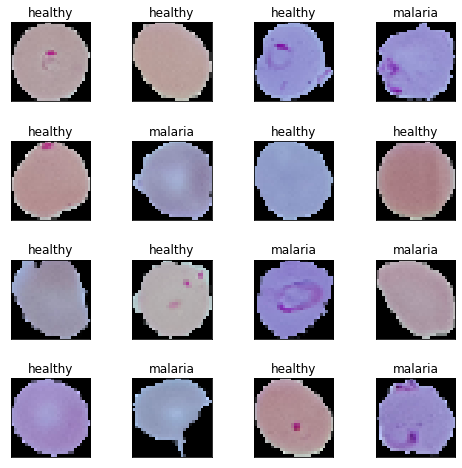

In [21]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i, sample_idx in enumerate(mask):
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][sample_idx]/255.)
    plt.title('{}'.format(predictions[i]))
    plt.xticks([]) , plt.yticks([])
plt.show()

## Testing of the LeNet with Receptive Field Property with Momentum by Using 28x28x3 images

In [27]:
net.loadWeights("../Malaria_Dataset/training_momentum_receptive_net_28/training_2recptive_28_epoch_3.txt")

n_values = 2
test_data_num = hdf5_file["test_labels"].shape[0]
#####################################################
# Since we don't want to load all the data at once, # 
# we need to divide it into batches. From the below #
# line you can change the batch size for the path.  #
#####################################################
TEST_BATCH_SIZE = 10
test_batches_list = list(range(int(ceil(float(test_data_num) / TEST_BATCH_SIZE))))
shuffle(test_batches_list)

num_of_correct_guesses = 0
num_of_correct_guesses_10 = 0

for n, i in enumerate(test_batches_list):
    i_s = i * TEST_BATCH_SIZE  # index of the first image in this batch
    i_e = min([(i + 1) * TEST_BATCH_SIZE, test_data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    test_images = hdf5_file["test_img"][i_s:i_e, ...]
    test_images = test_images.reshape(test_images.shape[0], test_images.shape[3],
                                      test_images.shape[1], test_images.shape[2]) # reshaped to size 22046, 3, 64, 64

    # read labels and convert to one hot encoding
    test_labels = hdf5_file["test_labels"][i_s:i_e]
    test_labels_one_hot = np.eye(n_values)[test_labels]

    temp = net.test(test_images / 255., test_labels_one_hot)
    num_of_correct_guesses += temp
    num_of_correct_guesses_10 += temp

    if n % 10 == 9:    # print every 10 batches
        print('Batch: {}, Accuracy: {}'.format(n+1,num_of_correct_guesses_10 * 100 / float(TEST_BATCH_SIZE * 10)))
        num_of_correct_guesses_10 = 0

print('Total test Accuracy : {}'.format(num_of_correct_guesses / float(test_data_num)))

Batch: 10, Accuracy: 62.0
Batch: 20, Accuracy: 67.0
Batch: 30, Accuracy: 58.0
Batch: 40, Accuracy: 61.0
Batch: 50, Accuracy: 65.0
Batch: 60, Accuracy: 58.0
Batch: 70, Accuracy: 66.0
Batch: 80, Accuracy: 71.0
Batch: 90, Accuracy: 59.0
Batch: 100, Accuracy: 63.0
Batch: 110, Accuracy: 67.0
Batch: 120, Accuracy: 57.0
Batch: 130, Accuracy: 64.0
Batch: 140, Accuracy: 60.0
Batch: 150, Accuracy: 63.0
Batch: 160, Accuracy: 61.0
Batch: 170, Accuracy: 60.0
Batch: 180, Accuracy: 57.0
Batch: 190, Accuracy: 65.0
Batch: 200, Accuracy: 62.0
Batch: 210, Accuracy: 68.0
Batch: 220, Accuracy: 63.0
Batch: 230, Accuracy: 61.0
Batch: 240, Accuracy: 70.0
Batch: 250, Accuracy: 67.0
Batch: 260, Accuracy: 60.0
Batch: 270, Accuracy: 57.0
Batch: 280, Accuracy: 70.0
Batch: 290, Accuracy: 64.0
Batch: 300, Accuracy: 68.0
Batch: 310, Accuracy: 62.0
Batch: 320, Accuracy: 65.0
Batch: 330, Accuracy: 63.0
Batch: 340, Accuracy: 57.0
Batch: 350, Accuracy: 62.0
Batch: 360, Accuracy: 62.0
Batch: 370, Accuracy: 66.0
Batch: 380

## Visual Test Results of LeNet Network Architecture with Receptive Field Properties by using Momentum

In [28]:
predictions = []
for sample_idx in mask:
    sample = hdf5_file["train_img"][sample_idx]/ 255.
    sample = sample.reshape(sample.shape[2], sample.shape[0], sample.shape[1])
    label = hdf5_file["train_labels"][sample_idx]
    predicted_label = net.predict(sample)
    if predicted_label == 0:
        predictions.append("healthy")
    else:
        predictions.append("malaria")

## Predictions

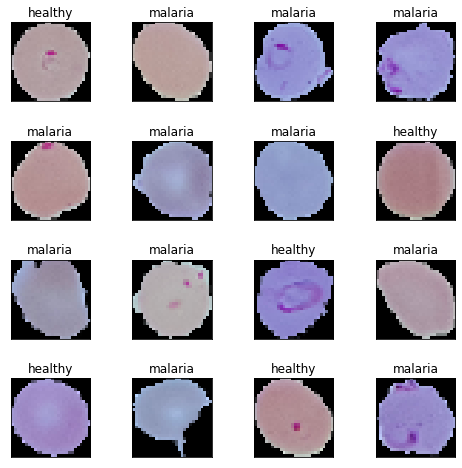

In [29]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i, sample_idx in enumerate(mask):
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(hdf5_file["train_img"][sample_idx]/255.)
    plt.title('{}'.format(predictions[i]))
    plt.xticks([]) , plt.yticks([])
plt.show()